In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_url = r"C:\Users\GIA BAO\OneDrive - Trường ĐH CNTT - University of Information Technology\FPT - Sheet1.csv"

In [3]:
data = pd.read_csv(csv_url, delimiter=';')
print(data)

            Date     Closed       Open        High        Low    Vol  Change
0     30/12/2016  15,852.00  15,707.90   15,942.10  15,617.80  3.79M   1.27%
1     03/01/2017  16,158.20  15,960.10   16,194.30  15,960.10  2.34M   1.93%
2     04/01/2017  16,302.30  16,140.20   16,464.50  16,104.20  2.36M   0.89%
3     05/01/2017  16,248.30  16,284.30   16,356.40  16,248.30  1.42M  -0.33%
4     06/01/2017  16,194.30  16,284.30   16,392.40  16,194.30  1.85M  -0.33%
...          ...        ...        ...         ...        ...    ...     ...
1736  13/12/2023  95,200.00  97,400.00   97,400.00  95,200.00  2.15M  -1.65%
1737  14/12/2023  96,200.00  95,800.00   96,400.00  95,200.00  1.71M   1.05%
1738  15/12/2023  96,200.00  96,200.00   96,300.00  95,000.00  1.47M   0.00%
1739  18/12/2023  94,000.00  95,900.00   96,200.00  93,700.00  2.27M  -2.29%
1740  19/12/2023  94,600.00  99,500.00  100,500.00  93,500.00  1.25M   0.64%

[1741 rows x 7 columns]


In [4]:
# Convert the 'Date' column to datetime with the correct format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [5]:
# Remove ',' and convert format
cols_to_convert = ['Closed', 'Open', 'High', 'Low']
data[cols_to_convert] = data[cols_to_convert].replace(',', '', regex=True).astype(float)

# Convert the format of the "Vol" column
def convert_vol(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '')) * 1e3
    else:
        return float(value)

data['Vol'] = data['Vol'].apply(convert_vol)

# Convert the format of the "Change" column
data['Change'] = data['Change'].replace('%', '', regex=True).astype(float) / 100.0
print(data)

             Closed     Open      High      Low        Vol  Change
Date                                                              
2016-12-30  15852.0  15707.9   15942.1  15617.8  3790000.0  0.0127
2017-01-03  16158.2  15960.1   16194.3  15960.1  2340000.0  0.0193
2017-01-04  16302.3  16140.2   16464.5  16104.2  2360000.0  0.0089
2017-01-05  16248.3  16284.3   16356.4  16248.3  1420000.0 -0.0033
2017-01-06  16194.3  16284.3   16392.4  16194.3  1850000.0 -0.0033
...             ...      ...       ...      ...        ...     ...
2023-12-13  95200.0  97400.0   97400.0  95200.0  2150000.0 -0.0165
2023-12-14  96200.0  95800.0   96400.0  95200.0  1710000.0  0.0105
2023-12-15  96200.0  96200.0   96300.0  95000.0  1470000.0  0.0000
2023-12-18  94000.0  95900.0   96200.0  93700.0  2270000.0 -0.0229
2023-12-19  94600.0  99500.0  100500.0  93500.0  1250000.0  0.0064

[1741 rows x 6 columns]


In [6]:
#Divide the data into Train-Test-Val sets with different ratios
def split_data(df, ratio):
    train, test_val = train_test_split(df, test_size=(1 - ratio[0]), shuffle=False)
    test, val = train_test_split(test_val, test_size=(ratio[2] / (ratio[1] + ratio[2])), shuffle=False)
    return train, test, val

#Ratio 6:3:1
train_data, test_data, val_data = split_data(data, [0.6, 0.3, 0.1])

In [7]:
features = ['Open', 'High', 'Low', 'Vol']
target = 'Closed'
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]
X_val, y_val = val_data[features], val_data[target]

In [8]:
#Training an SVR (Support Vector Regression) model
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

SVR()

In [9]:
#Evaluate the model on various datasets
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} MAPE: {mape:.2f}")

#Evaluate the model on Train datasets 
evaluate_model(model, X_train, y_train, "Train")

#Evaluate the model on Test datasets 
evaluate_model(model, X_test, y_test, "Test")

#Evaluate the model on Val datasets 
evaluate_model(model, X_val, y_val, "Val")

Train RMSE: 7787.99
Train MAE: 5924.61
Train MAPE: 21.34
Test RMSE: 52023.47
Test MAE: 51324.61
Test MAPE: 66.15
Val RMSE: 61995.70
Val MAE: 61655.41
Val MAPE: 70.42


In [12]:
# Create X_next_30_days DataFrame
next_30_days = pd.date_range(last_data, periods=30, freq='B')
X_next_30_days = pd.DataFrame(index=next_30_days, columns=features)

# Make predictions for train, test, and val sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Make predictions for the next 30 days
last_data = data.index[-1].strftime('%Y-%m-%d')
last_data = pd.to_datetime(last_data) + pd.DateOffset(days=1)
next_30_days = pd.date_range(last_data, periods=30, freq='B')
X_next_30_days = X_next_30_days.fillna(0)
y_next_30_days = model.predict(X_next_30_days)

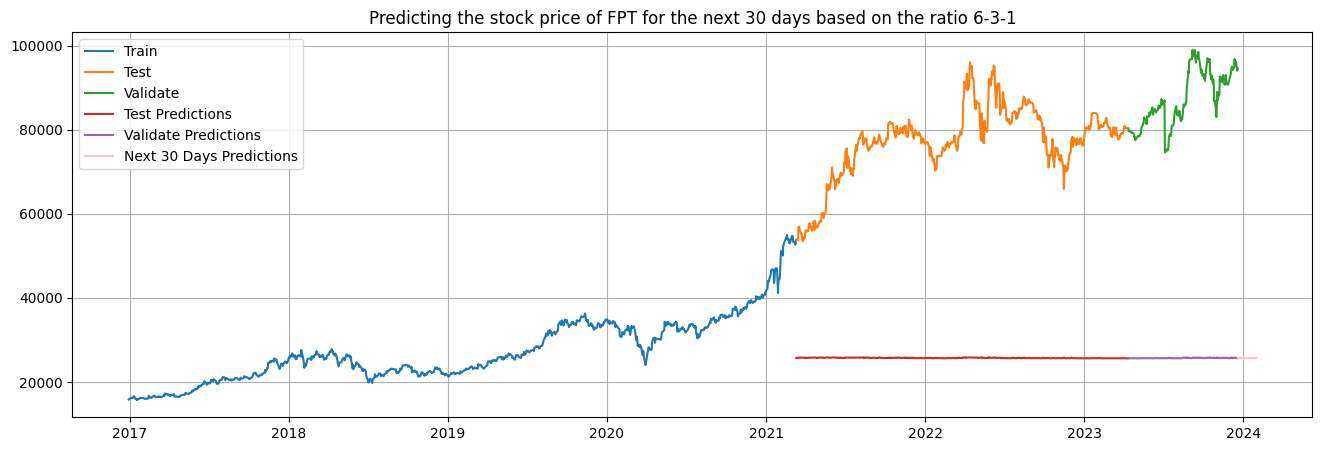

In [14]:
# Drawing plot
plt.figure(figsize=(16, 5))
plt.title("Predicting the stock price of FPT for the next 30 days based on the ratio 6-3-1")
plt.grid(True)
plt.plot(train_data.index, y_train, label='Train')
plt.plot(test_data.index, y_test, label='Test')
plt.plot(val_data.index, y_val, label='Validate')
plt.plot(test_data.index, y_pred_test, label='Test Predictions')
plt.plot(val_data.index, y_pred_val, label='Validate Predictions')
plt.plot(next_30_days, y_next_30_days, color="pink", label='Next 30 Days Predictions')
plt.legend()
plt.show()